# DIVAnd analysis for the Azores region

This example performs a temperature analysis using World Ocean Database
data from the Azores region.
The analysis is done for every season for the data from 2010 until end of 2014.

For testing purposes, let's start with a a limited number of vertical levels.

In [1]:
using DIVAnd
using DataStructures
using Dates
using Downloads: download
using NCDatasets
using PyPlot
using Statistics

Download the file `Temperature.nc` (if it is not already present). It will be placed in the same directory as this notebook. This file based on the World Ocean Database.

In [2]:
fname = "Azores-WOD-Temperature.nc"
if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/W5jIFPjXfSanRiO/download",fname)
else
    @info("Data file already downloaded")
end

[ Info: Data file already downloaded


Download the bathymetry if it is not already present

In [3]:
bathname = "gebco_30sec_16.nc"

if !isfile(bathname)
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

bathisglobal = true

[ Info: Bathymetry file already downloaded


true

Load the tmperature data from the file

In [4]:
varname = "Temperature"
obsval,obslon,obslat,obsdepth,obstime,obsid = DIVAnd.loadobs(Float64,fname,varname);
@show size(obsval);

size(obsval) = (1037505,)


The file contains about 1 000 000 measurements.
Print some basic statistics about the data. Keep an eye on the ranges.

In [5]:
checkobs((obslon,obslat,obsdepth,obstime),obsval,obsid)

              minimum and maximum of obs. dimension 1: (-32.992000579833984, -24.003999710083008)
              minimum and maximum of obs. dimension 2: (33.000999450683594, 39.99300003051758)
              minimum and maximum of obs. dimension 3: (0.0, 4359.8779296875)
              minimum and maximum of obs. dimension 4: (

[ Info: Checking ranges for dimensions and observations


DateTime("2010-01-01T05:54:21.961"), DateTime("2014-12-31T22:15:57.244"))
                          minimum and maximum of data: (-2.0999999046325684, 30.670000076293945)


Define the resolution. It is recommended to start with a low resolution and increase the resolution when the results are suitable.

In [6]:
dx = 0.1 # longitude resolution in degrees
dy = 0.1 # latitude resolution in degrees

0.1

Define the bounding box of the spatial domain

In [7]:
lonr = -33:dx:-24    # the range of longitudes (start:step:end)
latr = 33.0:dy:40.0  # the range of latitudes (start:step:end)

33.0:0.1:40.0

Define the depth levels

In [8]:
depthr = [0.,5., 10., 15., 20., 25., 30., 40., 50., 66,
    75, 85, 100, 112, 125, 135, 150, 175, 200, 225, 250,
    275, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750,
    800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250,
    1300, 1350, 1400, 1450, 1500, 1600, 1750, 1850, 2000]

# or for testing just a few levels
depthr = [0.,20.,50.]

@show size(depthr);

size(depthr) = (3,)


The error variance of the observation (scaled by the error variance of the background).
Note that this is the inverse of the signal-to-noise ratio used in the 2D version of `DIVA`.

In [9]:
epsilon2 = 0.2;

* Correlation length in meters (in x, y, and z directions)
* 300_000. is the same as 300000., but the former is easier to read.

In [10]:
sz = (length(lonr),length(latr),length(depthr))

lenx = fill(300_000.,sz)
leny = fill(300_000.,sz)
lenz = [10+depthr[k]/15 for i = 1:sz[1], j = 1:sz[2], k = 1:sz[3]];

Year range and averaging time window

In [11]:

# winter: January-March    1,2,3
# spring: April-June       4,5,6
# summer: July-September   7,8,9
# autumn: October-December 10,11,12

monthlists = [
    [1,2,3],
    [4,5,6],
    [7,8,9],
    [10,11,12]
];

* Other possible choises for the time selector are `TimeSelectorYearListMonthList` and `TimeSelectorRunningAverage`.
* Type `?` followed by these functions for more information

In [12]:
TS = TimeSelectorYearListMonthList([2010:2015],monthlists)

# File name based on the variable (but all spaces are replaced by _)
filename = "DIVAnd-analysis-$(lowercase(varname)).nc"

# Time origin for the NetCDF file
timeorigin = DateTime(1900,1,1,0,0,0)

# Extract the bathymetry for plotting
bx,by,b = DIVAnd.extract_bath(bathname,bathisglobal,lonr,latr);

A list of all metadata

In [13]:
metadata = OrderedDict(
    # Name of the project (SeaDataCloud, SeaDataNet, EMODNET-chemistry, ...)
    "project" => "SeaDataCloud",

    # URN code for the institution EDMO registry,
    # e.g. SDN:EDMO::1579
    "institution_urn" => "SDN:EDMO::1579",

    # Production group
    #"production" => "Diva group",

    # Name and emails from authors
    "Author_e-mail" => ["Your Name1 <name1@example.com>", "Other Name <name2@example.com>"],

    # Source of the observation
    "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network",

    # Additional comment
    "comment" => "...",

    # SeaDataNet Vocabulary P35 URN
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p35
    # example: SDN:P35::WATERTEMP
    "parameter_keyword_urn" => "SDN:P35::WATERTEMP",

    # List of SeaDataNet Parameter Discovery Vocabulary P02 URNs
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=p02
    # example: ["SDN:P02::TEMP"]
    "search_keywords_urn" => ["SDN:P02::TEMP"],

    # List of SeaDataNet Vocabulary C19 area URNs
    # SeaVoX salt and fresh water body gazetteer (C19)
    # http://seadatanet.maris2.nl/v_bodc_vocab_v2/search.asp?lib=C19
    # example: ["SDN:C19::3_1"]
    "area_keywords_urn" => ["SDN:C19::3_3"],

    "product_version" => "1.0",

    "product_code" => "something-to-decide",

    # bathymetry source acknowledgement
    # see, e.g.
    # * EMODnet Bathymetry Consortium (2016): EMODnet Digital Bathymetry (DTM).
    # https://doi.org/10.12770/c7b53704-999d-4721-b1a3-04ec60c87238
    #
    # taken from
    # http://www.emodnet-bathymetry.eu/data-products/acknowledgement-in-publications
    #
    # * The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003
    #
    # taken from
    # https://www.bodc.ac.uk/projects/data_management/international/gebco/gebco_digital_atlas/copyright_and_attribution/

    "bathymetry_source" => "The GEBCO Digital Atlas published by the British Oceanographic Data Centre on behalf of IOC and IHO, 2003",

    # NetCDF CF standard name
    # http://cfconventions.org/Data/cf-standard-names/current/build/cf-standard-name-table.html
    # example "standard_name" = "sea_water_temperature",
    "netcdf_standard_name" => "sea_water_temperature",

    "netcdf_long_name" => "sea water temperature",

    "netcdf_units" => "degree Celsius",

    # Abstract for the product
    "abstract" => "...",

    # This option provides a place to acknowledge various types of support for the
    # project that produced the data
    "acknowledgement" => "...",

    "documentation" => "https://doi.org/doi_of_doc",

    # Digital Object Identifier of the data product
    "doi" => "...")

OrderedDict{String, Any} with 18 entries:
  "project"               => "SeaDataCloud"
  "institution_urn"       => "SDN:EDMO::1579"
  "Author_e-mail"         => ["Your Name1 <name1@example.com>", "Other Name <na…
  "source"                => "observational data from SeaDataNet/EMODNet Chemis…
  "comment"               => "..."
  "parameter_keyword_urn" => "SDN:P35::WATERTEMP"
  "search_keywords_urn"   => ["SDN:P02::TEMP"]
  "area_keywords_urn"     => ["SDN:C19::3_3"]
  "product_version"       => "1.0"
  "product_code"          => "something-to-decide"
  "bathymetry_source"     => "The GEBCO Digital Atlas published by the British …
  "netcdf_standard_name"  => "sea_water_temperature"
  "netcdf_long_name"      => "sea water temperature"
  "netcdf_units"          => "degree Celsius"
  "abstract"              => "..."
  "acknowledgement"       => "..."
  "documentation"         => "https://doi.org/doi_of_doc"
  "doi"                   => "..."

* Make the NetCDF global and variable attributes based on the metadata.
* Custom attributes can be added by changing `ncglobalattrib`:

```julia
ncglobalattrib["attribute_name"] = "attribute_value"
```


In [14]:
ncglobalattrib,ncvarattrib = SDNMetadata(metadata,filename,varname,lonr,latr)

(OrderedDict("project" => "SeaDataCloud", "institution" => "University of Liège, GeoHydrodynamics and Environment Research", "institution_urn" => "SDN:EDMO::1579", "Author_e-mail" => "Your Name1 <name1@example.com>, Other Name <name2@example.com>", "source" => "observational data from SeaDataNet/EMODNet Chemistry Data Network", "comment" => "...", "parameter_keyword" => "ITS-90 water temperature", "parameter_keyword_urn" => "SDN:P35::WATERTEMP", "search_keywords" => "Temperature of the water column", "search_keywords_urn" => "SDN:P02::TEMP"…), OrderedDict("units" => "degree Celsius", "standard_name" => "sea_water_temperature", "long_name" => "sea water temperature"))

Plot the results near the surface for debugging and quick inspection.

To generate the plots, we define a function `plotres` (see next cell) that will be used as an optional argument when we call the interpolation with `DIVAnd`.

In [15]:
function plotres(timeindex,sel,fit,erri)
    tmp = copy(fit)
    tmp[erri .> .5] .= NaN;
    figure(figsize = (10,5))

    # select the data near the surface
    selsurface = sel .& (obsdepth .< 5)
    vmin,vmax = quantile(obsval[selsurface],(0.01,0.99))

    # plot the data
    subplot(1,2,1)
    scatter(obslon[selsurface],obslat[selsurface],10,obsval[selsurface];
            vmin = vmin, vmax = vmax)
    xlim(minimum(lonr),maximum(lonr))
    ylim(minimum(latr),maximum(latr))
    colorbar(orientation="horizontal")
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    gca().set_aspect(1/cosd(mean(by)))
    title("Observations (season $(timeindex))")

    # plot the analysis
    subplot(1,2,2)
    pcolor(lonr,latr,permutedims(tmp[:,:,1],[2,1]);
           vmin = vmin, vmax = vmax)
    colorbar(orientation="horizontal")
    contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])
    gca().set_aspect(1/cosd(mean(by)))
    title("Analysis (season $(timeindex))")
end

plotres (generic function with 1 method)

Launch the analysis. Plotting can be disabled by commenting the line containing `plotres`.

Here we use `diva3d`, which performs a series of 3D analyses (lon, lat and depth) for the different periods defined previously.

[ Info: Creating netCDF file DIVAnd-analysis-temperature.nc
[ Info: Time step 1 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(1, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/MV3j9/src/utils.jl:18
[ Info: number of windows: 1
[ Info: Time step 2 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 1

 49.774891 seconds (153.39 M allocations: 13.405 GiB, 8.38% gc time, 90.77% compilation time: 0% of which was recompilation)


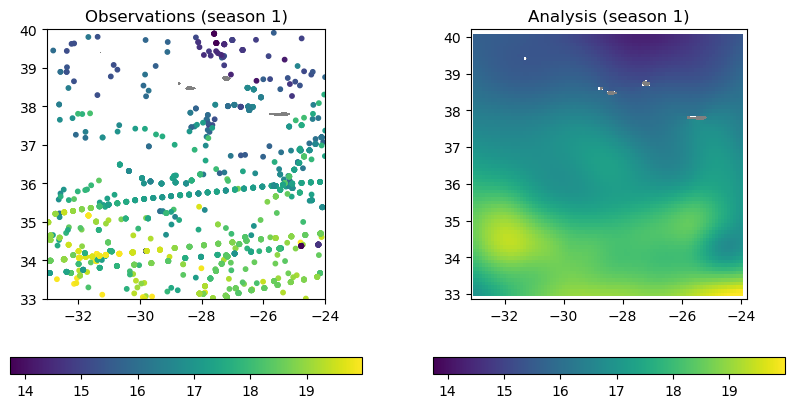

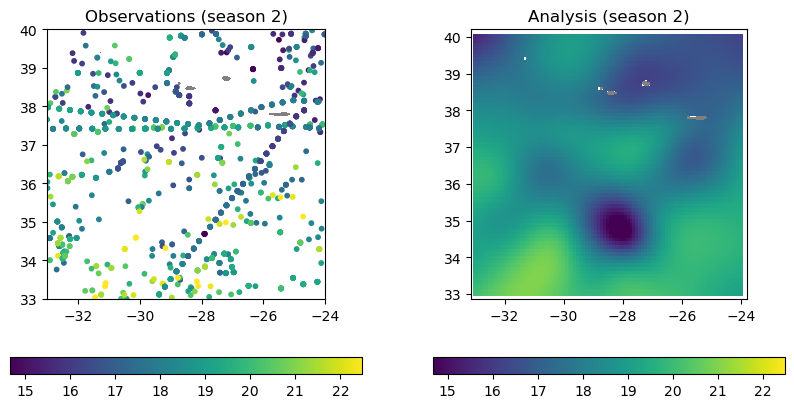

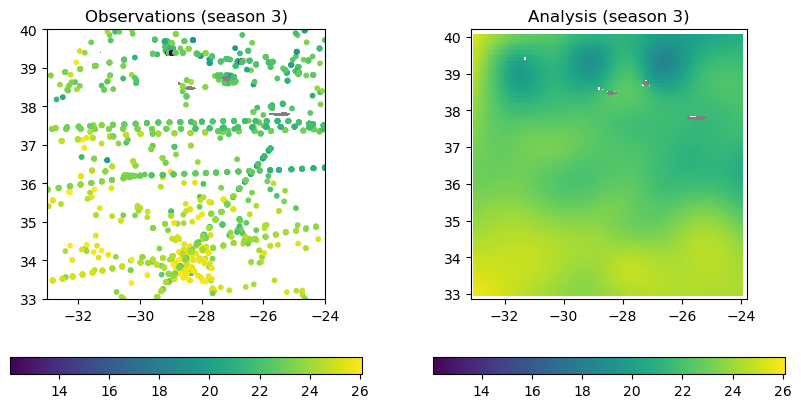

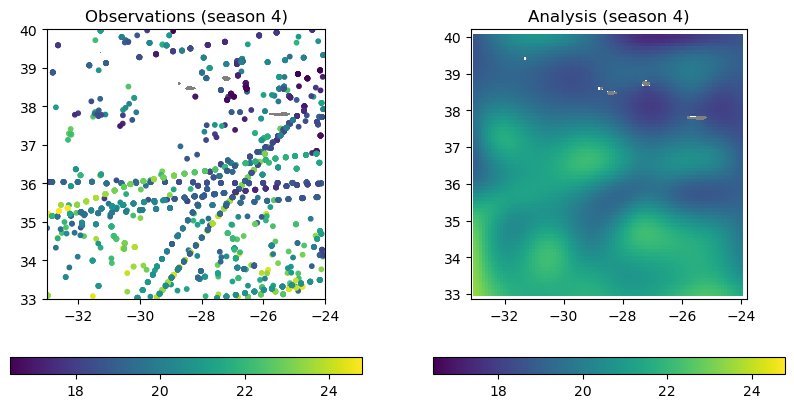

In [16]:
if isfile(filename)
   rm(filename) # delete the previous analysis
end

@time dbinfo = diva3d(
    (lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime),
    obsval,
    (lenx,leny,lenz),
    epsilon2,
    filename,varname,
    bathname = bathname,
    bathisglobal = bathisglobal,
    plotres = plotres,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    timeorigin = timeorigin,
    QCMETHOD = 0,
);


residual = dbinfo[:residuals];

This generates many plots (one for every time instance).
The number in the title is the time index starting with the first season and year.


Save the observation metadata in the NetCDF file

In [17]:
DIVAnd.saveobs(filename,(obslon,obslat,obsdepth,obstime),obsid)

# Residuals

Range of the residuals

In [18]:
res = dbinfo[:residuals]
@show extrema(res)

extrema(res) = (NaN, NaN)


(NaN, NaN)

Residuals with NaNs removed

In [19]:
res = residual[.!isnan.(residual)]

@show extrema(res);
@show quantile(res,[0.01,0.99]);

extrema(res) = (-19.726932525634766, 10.822675704956055)
quantile(res, [0.01, 0.99]) = [-3.3052630639076233, 3.6838078403472907]


Get the identifier of the anomalous point

In [20]:
i = findfirst(minimum(res) .== residual)
obsid[i]

"wod_015171276O"

For future analysis the residuals can also be saved.

In [21]:
resname = "$(varname)_residuals.nc"
if isfile(resname)
   rm(resname) # delete previous file if present
end

DIVAnd.saveobs(resname,"$(varname)_residual",residual,(obslon,obslat,obsdepth,obstime),obsid)

* Visualize the residuals (observations minus analysis)
* Change depth and time
* Adjust colorbare range (`clim`) to see large residuals

Number of data points: 210

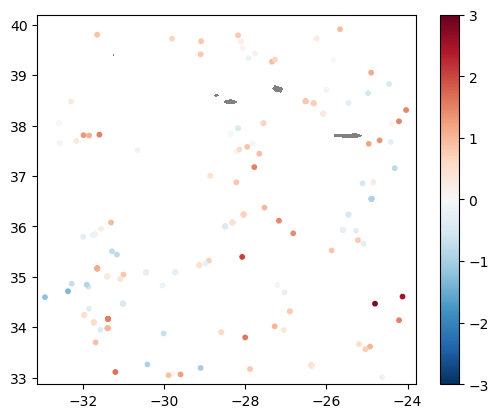

PyObject <matplotlib.contour.QuadContourSet object at 0x7f0c8e297400>

In [22]:
figure()
sel = (obsdepth .<  5) .& (Dates.month.(obstime) .== 1)
print("Number of data points: $(sum(sel))")
scatter(obslon[sel],obslat[sel],10,residual[sel]; cmap="RdBu_r")
clim(-3,3)
# set the correct aspect ratio
gca().set_aspect(1/cosd(mean(latr)))
colorbar();
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])

DIVAnd computes also a quality score (a-dimensional)
which can be used to remove bad data (or flag)

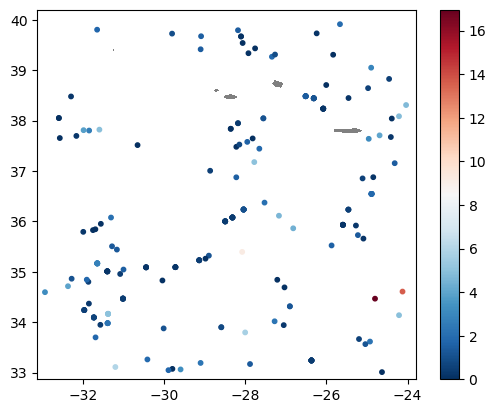

PyObject <matplotlib.contour.QuadContourSet object at 0x7f0c8e188760>

In [23]:
figure()
qcvalues = dbinfo[:qcvalues]
scatter(obslon[sel],obslat[sel],10,qcvalues[sel]; cmap="RdBu_r")
# set the correct aspect ratio
gca().set_aspect(1/cosd(mean(latr)))
colorbar()
contourf(bx,by,b', levels = [-1e5,0],colors = [[.5,.5,.5]])

Histgram of the quality score

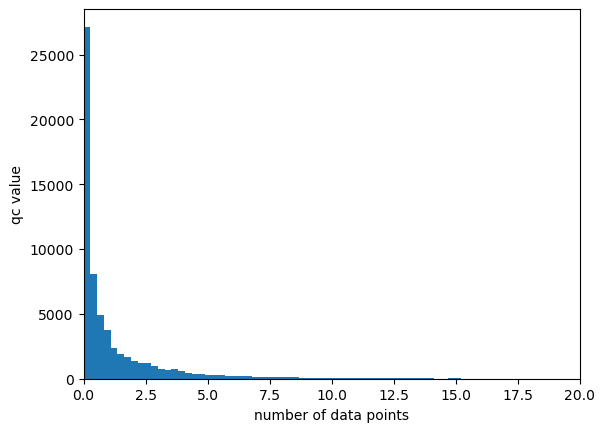

PyObject Text(24.0, 0.5, 'qc value')

In [24]:
figure()
hist(qcvalues,1000)
xlim(0,20)
xlabel("number of data points")
ylabel("qc value")

Choose a maximum value of the quality score

In [25]:
max_qcvalue = 7
good = qcvalues .< max_qcvalue;

# Final analysis
Repeat the analysis keeping only the good data

In [26]:
obslon,obslat,obsdepth,obstime = obslon[good],obslat[good],obsdepth[good],obstime[good]
obsval = obsval[good];

[ Info: Creating netCDF file DIVAnd-analysis-temperature.nc
[ Info: Time step 1 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 10.0 in dimension 3 at indices CartesianIndex(1, 1, 1) (skipping further tests). It is recommended that the resolution is at least 2 times finer than the correlation length.
└ @ DIVAnd ~/.julia/packages/DIVAnd/MV3j9/src/utils.jl:18
[ Info: number of windows: 1
[ Info: Time step 2 / 4
[ Info: scaled correlation length (min,max) in dimension 1: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 2: (300000.0, 300000.0)
[ Info: scaled correlation length (min,max) in dimension 3: (10.0, 13.333333333333334)
┌ Warning: resolution (20.0) is too coarse for correlation length 1

  6.532961 seconds (5.14 M allocations: 5.454 GiB, 16.61% gc time, 43.00% compilation time)


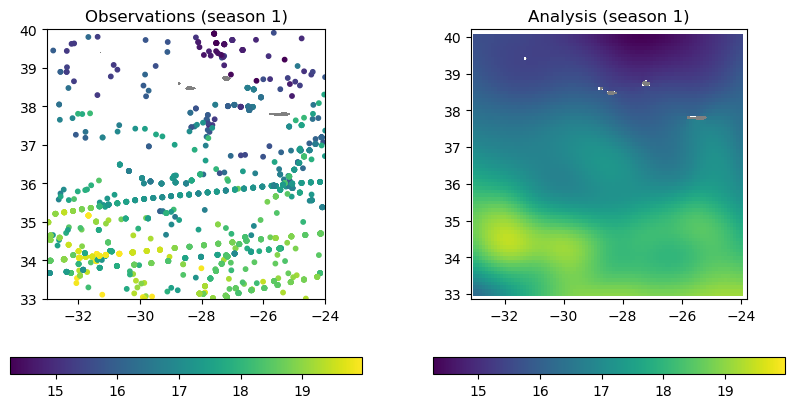

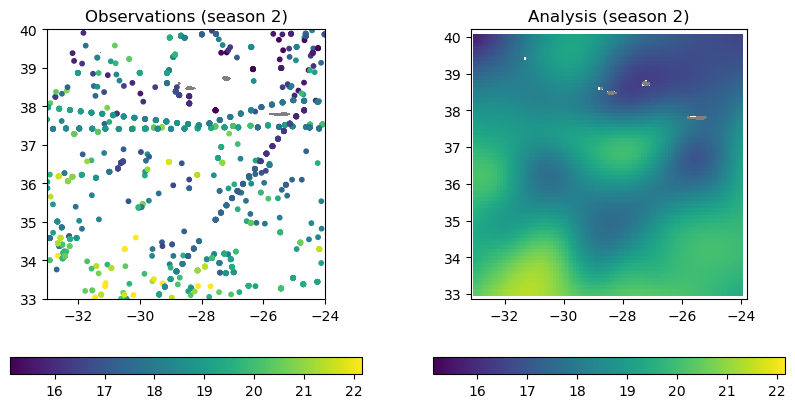

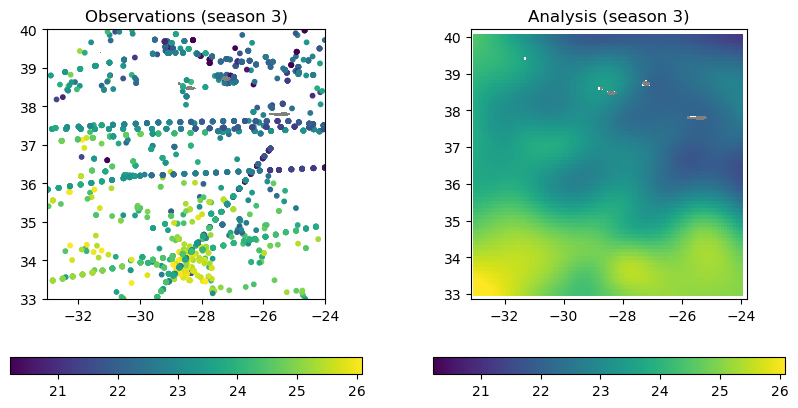

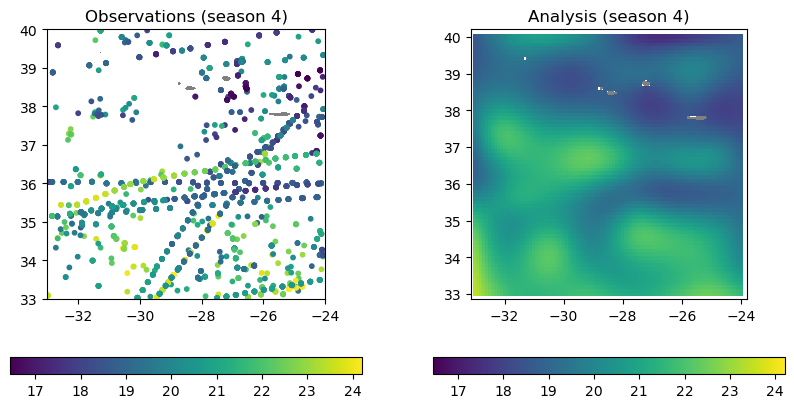

In [27]:
@time dbinfo = diva3d(
    (lonr,latr,depthr,TS),
    (obslon,obslat,obsdepth,obstime),
    obsval,
    (lenx,leny,lenz),
    epsilon2,
    filename,varname,
    bathname = bathname,
    bathisglobal = bathisglobal,
    plotres = plotres,
    ncvarattrib = ncvarattrib,
    ncglobalattrib = ncglobalattrib,
    timeorigin = timeorigin,
);